# Initialization

## Imports

In [1]:
from dataclasses import dataclass

import pandas as pd
import numpy as np
import random

# import plotly.io as pio
# pio.renderers.default = "vscode"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from contextlib import contextmanager

import pickle
import json
import os
from pathlib import Path
from os.path import join as pjoin
from tqdm.auto import tqdm
from copy import deepcopy
import shutil
from time import sleep

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as nn_parametrize

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Callback
from skorch.dataset import ValidSplit

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi']=120
matplotlib.rcParams['font.size'] = 14

## Args

In [3]:
@dataclass
class Args:
    outputs_dir: str = 'analysis'
    
    dataset_name: str = 'ao_clevr'
    data_dir: str = '' # empty = f'data/{args.dataset_name}'
    dataset_variant: str = 'VT'
    # dataset_variant: str = 'OZ'
    
    seen_seed:int = 0

    num_split:int = 5000
    init_seed: int = 0 # for torch seeding
    
    val_ratio: float = 0.2 # val/TRAIN (TRAIN = train + val, train = (1-val_ratio)/TRAIN)
    batch_size: int = 1024 # also for sampling multi-shifts (multi-shifted train) for MLLS training

    # only for OZ splits
    train_size: int = int(80e3)
    train_unseen_ovr_seen: float = 1e-2
    test_size: int = int(8e3)

    
args = Args()

In [4]:
if args.data_dir == '':
    args.data_dir = f'data/{args.dataset_name}'

## Definitions

In [5]:
def torch_setup(deterministic: bool = True):
    # Setting up torch, seeding (https://pytorch.org/docs/stable/notes/randomness.html)
    # ///////////// Making pytorch deterministic (reproducible)  ////////////////////////////////////////////////////
    if deterministic:
        # read WELL: https://pytorch.org/docs/stable/notes/randomness.html
        # the order of execution is important!

        # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
        #     os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8" # may limit overall performance
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # will increase library footprint in GPU memory by approximately 24MiB
        torch.backends.cudnn.benchmark = False
        print(f"executed: torch.backends.cudnn.benchmark = False")

        torch_set_deterministic = False
        # try:
        #     torch.set_deterministic(True) # beta in torch==1.7
        #     print(f"executed torch.set_deterministic(True)")
        #     torch_set_deterministic = True
        # except Exception as ex:
        #     logger.warning(f"torch.set_deterministic(True) failed: {ex}")
        try:
            torch.use_deterministic_algorithms(True)  # beta in torch==1.8
            print(f"executed: torch.use_deterministic_algorithms(True)")
            torch_set_deterministic = True
        except Exception as ex:
            print(f"torch.use_deterministic_algorithms(True) failed: {ex}")

        if not torch_set_deterministic:  # already contained in torch.use_deterministic_algorithms(True)
            torch.backends.cudnn.deterministic = True
            print(f"executed: torch.backends.cudnn.deterministic = True")

        print(f"torch and cuda will be deterministic (after seeding)")
    else:
        torch.backends.cudnn.benchmark = True
        print(f"executed: torch.backends.cudnn.benchmark = True (torch is not determinisitc!)")
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('torch is using %s (%s)'%(device, torch.cuda.get_device_name(device=0)))
    else:
        print('torch is using %s'%(device))
    return device

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed + 1000)
    torch.manual_seed(seed + 2000)
    torch.cuda.manual_seed(seed + 3000)
    print(f"completed: seeding with seed={seed} in steps of 1000 for random,np,torch,cuda")


## Yuval's defitions

In [6]:
if args.dataset_variant in ['VT', 'UV']:
    from typing import NamedTuple
    from pathlib import Path
    from ATTOP.data.dataset import sample_negative as ATTOP_sample_negative
    from torch.utils import data
    from COSMO_utils import temporary_random_numpy_seed


    def get_and_update_num_calls(func_ptr):
        try:
            get_and_update_num_calls.num_calls_cnt[func_ptr] += 1
        except AttributeError as e:
            if 'num_calls_cnt' in repr(e):
                get_and_update_num_calls.num_calls_cnt = defaultdict(int)
            else:
                raise

        return get_and_update_num_calls.num_calls_cnt[func_ptr]

    def categorical_histogram(data, labels_list, plot=True, frac=True, plt_show=False):
        import matplotlib.pyplot as plt
        s_counts = pd.Series(data).value_counts()
        s_frac = s_counts/s_counts.sum()
        hist_dict = s_counts.to_dict()
        if frac:
            hist_dict = s_frac.to_dict()
        hist = []
        for ix, _ in enumerate(labels_list):
            hist.append(hist_dict.get(ix, 0))

        if plot:
            pd.Series(hist, index=labels_list).plot(kind='bar')
            if frac:
                plt.ylim((0,1))
            if plt_show:
                plt.show()
        else:
            return np.array(hist, dtype='float32')

    class DataItem(NamedTuple):
        """ A NamedTuple for returning a Dataset item """
        feat: torch.Tensor
        pos_attr_id: int
        pos_obj_id: int
        neg_attr_id: int
        neg_obj_id: int
        image_fname: str


    class CompDataFromDict():
        # noinspection PyMissingConstructor
        def __init__(self, dict_data: dict, data_subset: str, data_dir: str):

            # define instance variables to be retrieved from struct_data_dict
            self.split: str = 'TBD'
            self.phase: str = 'TBD'
            self.feat_dim: int = -1
            self.objs: list = []
            self.attrs: list = []
            self.attr2idx: dict = {}
            self.obj2idx: dict = {}
            self.pair2idx: dict = {}
            self.seen_pairs: list = []
            self.all_open_pairs: list = []
            self.closed_unseen_pairs: list = []
            self.unseen_closed_val_pairs: list = []
            self.unseen_closed_test_pairs: list = []
            self.train_data: tuple = tuple()
            self.val_data: tuple = tuple()
            self.test_data: tuple = tuple()

            self.data_dir: str = data_dir

            # retrieve instance variables from struct_data_dict
            vars(self).update(dict_data)
            self.data = dict_data[data_subset]

            self.activations = {}
            features_dict = torch.load(Path(data_dir) / 'features.t7')
            for i, img_filename in enumerate(features_dict['files']):
                self.activations[img_filename] = features_dict['features'][i]

            self.input_shape = (self.feat_dim,)
            self.num_objs = len(self.objs)
            self.num_attrs = len(self.attrs)
            self.num_seen_pairs = len(self.seen_pairs)
            self.shape_obj_attr = (self.num_objs, self.num_attrs)

            self.flattened_seen_pairs_mask = self.get_flattened_pairs_mask(self.seen_pairs)
            self.flattened_closed_unseen_pairs_mask = self.get_flattened_pairs_mask(self.closed_unseen_pairs)
            self.flattened_all_open_pairs_mask = self.get_flattened_pairs_mask(self.all_open_pairs)
            self.seen_pairs_joint_class_ids = np.where(self.flattened_seen_pairs_mask)

            self.y1_freqs, self.y2_freqs, self.pairs_freqs = self._calc_freqs()
            self._just_load_labels = False

            self.train_pairs = self.seen_pairs

        def sample_negative(self, attr, obj):
            return ATTOP_sample_negative(self, attr, obj)

        def get_flattened_pairs_mask(self, pairs):
            pairs_ids = np.array([(self.obj2idx[obj], self.attr2idx[attr]) for attr, obj in pairs])
            flattened_pairs = np.zeros(self.shape_obj_attr, dtype=bool)  # init an array of False
            flattened_pairs[tuple(zip(*pairs_ids))] = True
            flattened_pairs = flattened_pairs.flatten()
            return flattened_pairs

        def just_load_labels(self, just_load_labels=True):
            self._just_load_labels = just_load_labels

        def get_all_labels(self):
            attrs = []
            objs = []
            joints = []
            self.just_load_labels(True)
            for attrs_batch, objs_batch in self:
                if isinstance(attrs_batch, torch.Tensor):
                    attrs_batch = attrs_batch.cpu().numpy()
                if isinstance(objs_batch, torch.Tensor):
                    objs_batch = objs_batch.cpu().numpy()
                joint = self.to_joint_label(objs_batch, attrs_batch)

                attrs.append(attrs_batch)
                objs.append(objs_batch)
                joints.append(joint)

            self.just_load_labels(False)
            attrs = np.array(attrs)
            objs = np.array(objs)
            return attrs, objs, joints

        def _calc_freqs(self):
            y2_train, y1_train, ys_joint_train = self.get_all_labels()
            y1_freqs = categorical_histogram(y1_train, range(self.num_objs), plot=False, frac=True)
            y1_freqs[y1_freqs == 0] = np.nan
            y2_freqs = categorical_histogram(y2_train, range(self.num_attrs), plot=False, frac=True)
            y2_freqs[y2_freqs == 0] = np.nan

            pairs_freqs = categorical_histogram(ys_joint_train,
                                                range(self.num_objs * self.num_attrs),
                                                plot=False, frac=True)
            pairs_freqs[pairs_freqs == 0] = np.nan
            return y1_freqs, y2_freqs, pairs_freqs

        def get(self, name):
            return vars(self).get(name)

        def __getitem__(self, idx):
            image_fname, attr, obj = self.data[idx]
            pos_attr_id, pos_obj_id = self.attr2idx[attr], self.obj2idx[obj]
            if self._just_load_labels:
                return pos_attr_id, pos_obj_id

            num_calls_cnt = get_and_update_num_calls(self.__getitem__)

            negative_attr_id, negative_obj_id = -1, -1  # default values
            if self.phase == 'train':
                # we set a temp np seed to override a weird issue with
                # sample_negative() at __getitem__, where the sampled pairs
                # could not be deterministically reproduced:
                # Now at each call to _getitem_ we set the seed to a 834276 (chosen randomly) + the number of calls to _getitem_
                with temporary_random_numpy_seed(834276 + num_calls_cnt):
                    # draw a negative pair
                    negative_attr_id, negative_obj_id = self.sample_negative(attr, obj)

            item = DataItem(
                feat=self.activations[image_fname],
                pos_attr_id=pos_attr_id,
                pos_obj_id=pos_obj_id,
                neg_attr_id=negative_attr_id,
                neg_obj_id=negative_obj_id,
                image_fname=image_fname,
            )
            return item

        def __len__(self):
            return len(self.data)

        def to_joint_label(self, y1_batch, y2_batch):
            return (y1_batch * self.num_attrs + y2_batch)


    def get_data_loaders(train_dataset, valid_dataset, test_dataset, batch_size,
                        num_workers=10, test_batchsize=None, shuffle_eval_set=True):
        if test_batchsize is None:
            test_batchsize = batch_size

        pin_memory = True
        if num_workers == 0:
            pin_memory = False
        print('num_workers = ', num_workers)
        print('pin_memory = ', pin_memory)
        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                                    pin_memory=pin_memory)
        valid_loader = None
        if valid_dataset is not None and len(valid_dataset) > 0:
            valid_loader = data.DataLoader(valid_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                        num_workers=num_workers, pin_memory=pin_memory)
        test_loader = data.DataLoader(test_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                    num_workers=num_workers, pin_memory=pin_memory)
        return test_loader, train_loader, valid_loader

# Loading data

## Getting global combinations

In [7]:
label_cols = ['shape', 'color']
# --------------------------------

meta_df = pd.read_csv(pjoin(args.data_dir, 'objects_metadata.csv'))
global_label_combs = meta_df[label_cols].groupby(label_cols).size()
global_label_combs.name = 'global samples'
global_label_combs = global_label_combs.reset_index()
global_label_combs['global freq'] = global_label_combs['global samples']/global_label_combs['global samples'].sum()
global_label_combs.index.name = 'comb idx'
global_label_combs = global_label_combs.reset_index()
global_label_combs

,comb idx,shape,color,global samples,global freq
0,0,cube,blue,7520,0.041778
1,1,cube,brown,7508,0.041711
2,2,cube,cyan,7344,0.040800
3,3,cube,gray,7552,0.041956
4,4,cube,green,7346,0.040811
5,5,cube,purple,7565,0.042028
6,6,cube,red,7458,0.041433
7,7,cube,yellow,7707,0.042817
8,8,cylinder,blue,7338,0.040767
9,9,cylinder,brown,7455,0.041417


In [8]:
distinct_label_n_vals = {label: len(global_label_combs[label].unique()) for label in label_cols}
distinct_label_n_vals

{'shape': 3, 'color': 8}

## (A) Oz's splits, data

### Sampling distributions

In [9]:
if args.dataset_variant == 'OZ':
    num_split_str = str(args.num_split)
    unseen_ovr_tot = int(num_split_str[:2])/100
    data_seed = int(num_split_str[3:])

    invalid_sampling = True
    max_i_sampling = 100
    i_sampling = 0

    while invalid_sampling:
        unseen_label_dist = global_label_combs.sample(frac=unseen_ovr_tot,
            random_state=data_seed+i_sampling)
        unseen_distinct_label_n_vals = {label: len(unseen_label_dist[label].unique()) for label in label_cols}
        if unseen_distinct_label_n_vals == distinct_label_n_vals:
            invalid_sampling = False
            print(f"succeeded sampling with all unique label values in iteration {i_sampling}")
        i_sampling += 1
        if i_sampling >= max_i_sampling:
            print(f"reached max iterations ({max_i_sampling}) without success in sampling with all unique label values ")
            break

In [10]:
if args.dataset_variant == 'OZ':
    seen_combs_idx = set(global_label_combs.index) - set(unseen_label_dist.index)
    seen_label_dist = global_label_combs.loc[seen_combs_idx]
    assert len(set(seen_label_dist.index) & set(unseen_label_dist.index)) == 0

    label_dists_df = global_label_combs.copy()
    label_dists_df.loc[seen_label_dist.index, 'train prob'] = 1/len(seen_label_dist)
    label_dists_df.loc[seen_label_dist.index, 'state'] = 'seen'
    label_dists_df.loc[unseen_label_dist.index, 'train prob'] =\
        args.train_unseen_ovr_seen / len(seen_label_dist)
    label_dists_df.loc[unseen_label_dist.index, 'state'] = 'unseen'
    label_dists_df['train prob'] = label_dists_df['train prob'] / label_dists_df['train prob'].sum()
    label_dists_df['test prob'] =  1/len(label_dists_df)
    display(label_dists_df)

### Sampling samples

In [11]:
if args.dataset_variant == 'OZ':
    meta_df_ = meta_df.merge(label_dists_df, on=label_cols, how='outer')
    meta_df_ = meta_df_.sample(frac=1, random_state=data_seed)

    for i_row in range(len(label_dists_df)):
        row = label_dists_df.iloc[i_row]
        comb_idx = row['comb idx']
        comb_samples = meta_df_.query(f"`comb idx` == {comb_idx}")

        # selecting train
        n_samples_train = round(args.train_size * row['train prob'])
        assert n_samples_train <= len(comb_samples)
        meta_df_.loc[comb_samples.index[:n_samples_train], 'phase'] = 'train'

        # selecting test
        n_samples_test = round(args.test_size * row['test prob'])
        assert n_samples_test <= len(comb_samples) - n_samples_train
        meta_df_.loc[comb_samples.index[
            n_samples_train: n_samples_train+n_samples_test], 'phase'] = 'test'

### Verifying

In [12]:
if args.dataset_variant == 'OZ':
    for phase in ['train', 'test']:
        label_dists_df[f'{phase} samples'] = meta_df_.query(f"phase == '{phase}'")['comb idx'].value_counts()
        label_dists_df[f'{phase} freq'] = label_dists_df[f'{phase} samples']/label_dists_df[f'{phase} samples'].sum()
    display(label_dists_df)

### Preparing data

In [13]:
if args.dataset_variant == 'OZ':
    features_dict = torch.load(pjoin(args.data_dir, 'features.t7'))
    features_dict_ = {file:tensor for file, tensor in zip(
        features_dict['files'], features_dict['features'])}

    idx = 5
    assert torch.equal(features_dict_[features_dict['files'][idx]], features_dict['features'][idx])
    del features_dict

In [14]:
if args.dataset_variant == 'OZ':
    X, Y_comb = {}, {}
    for phase in ['train', 'test']:
        data_df = meta_df_.query(f"phase == '{phase}'")

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')
        print(f"{phase} contains {len(data_df)} samples")

        X[phase] = torch.cat([features_dict_[filename].unsqueeze(0)
            for filename in data_df['image_filename']], dim=0)
    del features_dict_

## (B) Yuval's splits, dataloaders

In [15]:
if args.dataset_variant in ['VT', 'UV']:
    meta_path = Path(f"{args.data_dir}/metadata_pickles")
    random_state_path = Path(f"{args.data_dir}/np_random_state_pickles")
    # meta_path = meta_path.expanduser()

    dict_data = dict()

    for subset in ['train', 'valid', 'test']:
        metadata_full_filename = meta_path / f"metadata_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}__{subset}.pkl"
        dict_data[f'{subset}'] = deepcopy(pickle.load(open(metadata_full_filename, 'rb')))

    np_rnd_state_fname = random_state_path / f"np_random_state_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}.pkl"
    np_seed_state = pickle.load(open(np_rnd_state_fname, 'rb'))
    np.random.set_state(np_seed_state)

    datasets = {}
    for phase in ['train', 'val', 'test']:
        datasets[phase] = CompDataFromDict(dict_data[phase if phase!='val' else 'valid'],
            data_subset=f'{phase}_data', data_dir=args.data_dir)

### Preparing data

In [16]:
if args.dataset_variant in ['VT', 'UV']:
    X, Y_comb = {}, {}
    label_dists_df = global_label_combs.copy()
    for phase, dataset in datasets.items():
        dataset = datasets[phase]
        data_df = pd.DataFrame(dataset.data, columns=['filename', 'color', 'shape'])
        data_df = data_df.merge(label_dists_df, on=label_cols)

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')
        print(f"{phase} contains {len(data_df)} samples")

        features = dataset.activations
        X[phase] = torch.cat([features[filename].unsqueeze(0)
            for filename in data_df['filename']], dim=0)

        dist_df = data_df.groupby(label_cols).size()
        dist_df.name = f'{phase} samples'
        dist_df = dist_df.reset_index()
        dist_df[f'{phase} freq'] = dist_df[f'{phase} samples']/dist_df[f'{phase} samples'].sum()
        label_dists_df = label_dists_df.merge(dist_df, on=label_cols, how='outer')

    label_dists_df = label_dists_df.set_index('comb idx')
    label_dists_df.loc[label_dists_df['train freq'].isna(), 'state'] = 'unseen'
    label_dists_df.loc[~label_dists_df['train freq'].isna(), 'state'] = 'seen'
    
    display(label_dists_df)

train contains 80958 samples
val contains 4678 samples
test contains 7720 samples


,shape,color,global samples,global freq,train samples,train freq,val samples,val freq,test samples,test freq,state
comb idx,,,,,,,,,,,
0,cube,blue,7520,0.041778,6841.0,0.084501,373,0.079735,306,0.039637,seen
1,cube,brown,7508,0.041711,6790.0,0.083871,376,0.080376,342,0.044301,seen
2,cube,cyan,7344,0.040800,NaN,NaN,5,0.001069,300,0.038860,unseen
3,cube,gray,7552,0.041956,6793.0,0.083908,405,0.086575,354,0.045855,seen
4,cube,green,7346,0.040811,6611.0,0.081660,390,0.083369,345,0.044689,seen
5,cube,purple,7565,0.042028,NaN,NaN,5,0.001069,300,0.038860,unseen
6,cube,red,7458,0.041433,NaN,NaN,5,0.001069,300,0.038860,unseen
7,cube,yellow,7707,0.042817,NaN,NaN,5,0.001069,300,0.038860,unseen
8,cylinder,blue,7338,0.040767,6658.0,0.082240,382,0.081659,298,0.038601,seen


## Analyzing

In [17]:
n_unseen = len(label_dists_df.query(f"state == 'seen'"))
n_seen = len(label_dists_df.query(f"state == 'unseen'"))
assert len(label_dists_df) == n_unseen + n_seen
print(f"n_unseen / n_total = {n_unseen} / {len(label_dists_df)} = {n_unseen/len(label_dists_df)}")

n_unseen / n_total = 12 / 24 = 0.5


In [18]:
for phase in ['train', 'test']:
    print(f"{phase} distribution:")
    # with pd.option_context('display.float_format',"{:,.4f}".format):
    #     display(label_dists_df.pivot(index='shape', columns='color', values=f'{phase} freq'))
    display(label_dists_df.pivot(index='shape', columns='color', values=f'{phase} samples'))

train distribution:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,6841.0,6790.0,NaN,6793.0,6611.0,NaN,NaN,NaN
cylinder,6658.0,NaN,NaN,6809.0,NaN,6733.0,NaN,NaN
sphere,6786.0,6717.0,NaN,6656.0,NaN,NaN,6681.0,6883.0


test distribution:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,306,342,300,354,345,300,300,300
cylinder,298,300,300,378,300,376,300,300
sphere,355,328,300,334,300,300,358,346


# MLP for multi-label combinations (CE)

## Net initialization

In [19]:
device = torch_setup(deterministic=True)
seed_all(args.init_seed)

in_dim = X['train'].shape[1]
out_dim = len(global_label_combs)

assert in_dim == 512
Net_combs = nn.Sequential(
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, out_dim),
)

net_combs = NeuralNetClassifier(
    Net_combs,
    max_epochs=25,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD,
    lr=1e-1,
    batch_size=args.batch_size,
    iterator_train__shuffle=True,
    train_split=ValidSplit(cv=args.val_ratio, stratified=True),
    device=device,
    callbacks=[EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True),
              ],
)
net_combs

executed: torch.backends.cudnn.benchmark = False
executed: torch.use_deterministic_algorithms(True)
torch and cuda will be deterministic (after seeding)
torch is using cuda:0 (NVIDIA GeForce GTX 960M)
completed: seeding with seed=0 in steps of 1000 for random,np,torch,cuda


<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=64, out_features=24, bias=True)
  ),
)

## Training

In [20]:
net_combs.fit(X['train'], Y_comb['train']);

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.6091        1.1648       0.7161        0.5766  3.6462
      2      0.7769        0.4848       0.7089        0.5690  1.2176
      3      0.8013        0.4192       0.7940        0.4286  1.0997
      4      0.8205        0.3836       0.7693        0.4323  1.0861
      5      0.8327        0.3529       0.8019        0.4744  1.1140
      6      0.8420        0.3419       0.8532        0.3123  1.0980
      7      0.8475        0.3297       0.8788        0.2866  1.1340
      8      0.8569        0.3125       0.8701        0.2865  1.1226
      9      0.8648        0.2956       0.8891        0.2556  1.1699
     10      0.8710        0.2833       0.8200        0.3502  1.3939
     11      0.8736        0.2787       0.8500        0.3293  1.1160
     12      0.8835        0.2669       0.8719        0.2742  1.0810
     13      0.8798        0.2632 

## Evaluation

In [21]:
Y_comb_probs = {phase: net_combs.predict_proba(X[phase]) for phase in ['train', 'test']}
for phase in ['train', 'test']:
#     assert set(np.unique(Y[phase])) == {0,1} # "EM below assumes labels are binary!"
    print(f"(Y_comb_probs[{phase}].sum(axis=1) - 1).mean(): %.12f"%(Y_comb_probs[phase].sum(axis=1) - 1).mean())
#     print(f"Y_comb_probs[{phase}].sum(axis=1)")
#     display(Y_comb_probs[phase].sum(axis=1))
    # assert (Y_comb_probs[phase].sum(axis=1) - 1).mean() == 0, 'EM requires probs (normalized)!'
Y_comb_probs['test']

(Y_comb_probs[train].sum(axis=1) - 1).mean(): 0.000000002538
(Y_comb_probs[test].sum(axis=1) - 1).mean(): 0.000000001328


array([[6.4037631e-05, 3.1430295e-07, 9.4671492e-08, ..., 8.4918192e-08,
        6.5416284e-04, 1.3199973e-07],
       [1.7353959e-06, 9.6169963e-08, 1.3074973e-09, ..., 3.4797018e-10,
        1.1903985e-06, 5.5005445e-11],
       [5.5976369e-04, 1.5901777e-07, 3.1623136e-07, ..., 1.5464975e-07,
        1.4475772e-04, 2.2493469e-07],
       ...,
       [1.6062420e-03, 3.7333153e-10, 1.6906625e-08, ..., 2.3259050e-08,
        4.5820298e-10, 6.1227474e-11],
       [2.3110560e-01, 1.0379280e-09, 7.0989461e-07, ..., 3.4928362e-07,
        1.1338108e-07, 6.3709990e-08],
       [1.8609004e-02, 6.8442305e-09, 2.0370341e-07, ..., 1.7492287e-07,
        1.7395674e-08, 1.4567594e-09]], dtype=float32)

In [22]:
Y_comb_pred = {phase: Y_comb_probs[phase].argmax(axis=1) for phase in ['train', 'test']}
Y_comb_pred['test']

array([13, 13, 13, ...,  8,  8,  8], dtype=int64)

In [23]:
for phase in ['train', 'test']:
    y = Y_comb[phase]
    y_pred = Y_comb_pred[phase]
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'multi-class: {phase} soft pred prior'] = pd.Series(Y_comb_probs[phase].mean(0))
    label_dists_df[f'multi-class: {phase} true pos'] = true_pos
    label_dists_df[f'multi-class: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

,shape,color,global samples,global freq,train samples,train freq,val samples,val freq,test samples,test freq,state,multi-class: train soft pred prior,multi-class: train true pos,multi-class: train acc,multi-class: test soft pred prior,multi-class: test true pos,multi-class: test acc
comb idx,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,6841.0,0.084501,373,0.079735,306,0.039637,seen,0.071852,4834.0,0.706622,0.061789,212.0,0.692810
1,cube,brown,7508,0.041711,6790.0,0.083871,376,0.080376,342,0.044301,seen,0.084775,6656.0,0.980265,0.081641,334.0,0.976608
2,cube,cyan,7344,0.040800,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000011,NaN,NaN,0.000011,NaN,NaN
3,cube,gray,7552,0.041956,6793.0,0.083908,405,0.086575,354,0.045855,seen,0.086750,5646.0,0.831150,0.049058,296.0,0.836158
4,cube,green,7346,0.040811,6611.0,0.081660,390,0.083369,345,0.044689,seen,0.081577,6609.0,0.999697,0.176642,345.0,1.000000
5,cube,purple,7565,0.042028,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000008,NaN,NaN,0.000009,NaN,NaN
6,cube,red,7458,0.041433,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000009,NaN,NaN,0.000009,NaN,NaN
7,cube,yellow,7707,0.042817,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000014,NaN,NaN,0.000012,NaN,NaN
8,cylinder,blue,7338,0.040767,6658.0,0.082240,382,0.081659,298,0.038601,seen,0.088110,6088.0,0.914389,0.091092,281.0,0.942953


In [24]:
result_cols = ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
results_df = label_dists_df[result_cols].sort_values(by='train freq', ascending=False)
results_df_styled = results_df.style.format("{:.1%}").background_gradient(cmap='Greens')
results_df_styled

,train freq,test freq,multi-class: train acc,multi-class: test acc
comb idx,,,,
23,8.5%,4.5%,100.0%,100.0%
0,8.5%,4.0%,70.7%,69.3%
11,8.4%,4.9%,85.3%,84.1%
3,8.4%,4.6%,83.1%,83.6%
1,8.4%,4.4%,98.0%,97.7%
16,8.4%,4.6%,99.0%,98.3%
13,8.3%,4.9%,100.0%,100.0%
17,8.3%,4.2%,97.9%,97.0%
22,8.3%,4.6%,100.0%,100.0%


In [25]:
result_cols = label_cols + ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
results_df = label_dists_df[result_cols]
# results_df = results_df.sort_values(by='train freq', ascending=False)
with pd.option_context('display.float_format',"{:,.1%}".format):
    display(results_df)

,shape,color,train freq,test freq,multi-class: train acc,multi-class: test acc
comb idx,,,,,,
0,cube,blue,8.5%,4.0%,70.7%,69.3%
1,cube,brown,8.4%,4.4%,98.0%,97.7%
2,cube,cyan,NaN,3.9%,NaN,NaN
3,cube,gray,8.4%,4.6%,83.1%,83.6%
4,cube,green,8.2%,4.5%,100.0%,100.0%
5,cube,purple,NaN,3.9%,NaN,NaN
6,cube,red,NaN,3.9%,NaN,NaN
7,cube,yellow,NaN,3.9%,NaN,NaN
8,cylinder,blue,8.2%,3.9%,91.4%,94.3%


In [26]:
for phase in ['train', 'test']:
    print(f'multi-class combs net - {phase} soft predicted prior (mean of probs):')
    with pd.option_context('display.float_format',"{:,.3%}".format):
        display(label_dists_df.pivot(index='shape', columns='color', values=f'multi-class: {phase} soft pred prior'))

multi-class combs net - train soft predicted prior (mean of probs):


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,7.185%,8.477%,0.001%,8.675%,8.158%,0.001%,0.001%,0.001%
cylinder,8.811%,0.002%,0.001%,8.052%,0.002%,8.317%,0.001%,0.001%
sphere,9.019%,8.227%,0.001%,8.303%,0.001%,0.001%,8.255%,8.501%


multi-class combs net - test soft predicted prior (mean of probs):


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,6.179%,8.164%,0.001%,4.906%,17.664%,0.001%,0.001%,0.001%
cylinder,9.109%,0.001%,0.001%,4.496%,0.002%,11.938%,0.001%,0.001%
sphere,7.102%,4.499%,0.001%,4.501%,0.001%,0.001%,12.724%,8.704%


# Full EM

## Adding noise to unseen combs

In [27]:
EM_meta_df = label_dists_df[['train freq', 'test freq']].copy()
EM_meta_df['mean test prob'] = Y_comb_probs['test'].mean(0)
EM_meta_df

,train freq,test freq,mean test prob
comb idx,,,
0,0.084501,0.039637,0.061789
1,0.083871,0.044301,0.081641
2,NaN,0.038860,0.000011
3,0.083908,0.045855,0.049058
4,0.081660,0.044689,0.176642
5,NaN,0.038860,0.000009
6,NaN,0.038860,0.000009
7,NaN,0.038860,0.000012
8,0.082240,0.038601,0.091092


In [28]:
seen_mean_prob = EM_meta_df.loc[~EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
unseen_mean_prob = EM_meta_df.loc[EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
print("mean prob - seen, unseen = %.2e, %.2e"%(seen_mean_prob, unseen_mean_prob))

mean prob - seen, unseen = 8.33e-02, 1.10e-05


In [29]:
# factor = np.ones_like(Y_comb_probs['test'])
# factor[:, label_dists_df['train freq'].isna().values] = 100
# factor[0][label_dists_df['train freq'].isna().values]

## EM

In [31]:
EM_iterations = 100
# EM_iterations = 10

init_prior = 'source prior'
# init_prior = 'uniform'

prior_source_phase = 'est. soft train'
# prior_source_phase = 'est. soft test'
# prior_source_phase = 'true train'
# prior_source_phase = 'true test'
# prior_source_phase = 'uniform'

soft_prior = True # proper EM: SOFT prior_shift_pred = shift_probs.mean(axis=0)
# soft_prior = False # improper EM: HARD prior_shift_pred (calculated from hist)
over_update_probs = False # proper EM shift_probs = shift_probs_0 * prior_shift_pred / prior_train
# over_update_probs = True # improper EM shift_probs = shift_probs * prior_shift_pred / prior_train

n_combs = len(label_dists_df)
# -------------------------------------
    
if (not soft_prior) or over_update_probs or (prior_source_phase != 'est. soft train'):
    confirm_ui = input("confirm performing an IMPROPER EM for debugging, " \
        "(for a proper EM, set: soft_prior = True, over_update_probs = False, "\
        "prior_source_phase = 'est. soft train'): y/[n] ")
    if confirm_ui != 'y':
        raise RuntimeError("terminated by user")

if 'est. soft' in prior_source_phase:
    Y_probs_source = Y_comb_probs['test' if 'test' in prior_source_phase else 'train']
    prior_source = Y_probs_source.mean(axis=0)
elif 'true' in prior_source_phase:
    Y_source = Y_comb['test' if 'test' in prior_source_phase else 'train']
    hist = np.bincount(Y_source, minlength=n_combs)
    prior_source = hist / hist.sum()
elif prior_source_phase == 'uniform':
    prior_source = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

print(f"source prior ('{prior_source_phase}'):")
display(prior_source)

# init
EM_results = pd.DataFrame(index=range(EM_iterations))
EM_results.index.name = 'iteration'
shift_labels = Y_comb['test']
shift_probs_0 = Y_comb_probs['test']
shift_probs = shift_probs_0

if init_prior == 'source prior':
    prior_shift_pred = prior_source
elif init_prior == 'uniform':
    prior_shift_pred = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

# eval
shift_preds = shift_probs.argmax(axis=1)
positives = shift_preds==shift_labels
# EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
EM_results.loc[0, 'accuracy'] = positives.mean()
# likelihood
Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

# EM
for i_EM in tqdm(range(1, 1+EM_iterations)):        
    # E-step
    if over_update_probs:
        shift_probs = shift_probs * prior_shift_pred / prior_source
    else:
        shift_probs = shift_probs_0 * prior_shift_pred / prior_source
    shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
    
    shift_preds = shift_probs.argmax(axis=1)
    
    # eval
    positives = shift_preds==shift_labels
    EM_results.loc[i_EM, 'accuracy'] = positives.mean()
    # likelihood
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
    EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # M-step
    if soft_prior:
        prior_shift_pred = shift_probs.mean(axis=0)
    else:
        hist_shift_pred = np.bincount(shift_preds, minlength=args.n_classes_per_label * args.n_labels)
        prior_shift_pred = hist_shift_pred / hist_shift_pred.sum()

assert (~np.isfinite(shift_probs)).sum() == 0
# full_EM_evolution, full_EM_shift_probs = EM(Y=Y_comb, Y_probs=Y_comb_probs, EM_iterations=EM_iterations,
#     prior_source_phase=prior_source_phase, init_prior=init_prior, n_combs=len(label_dists_df),
#     soft_prior=soft_prior, over_update_probs=over_update_probs)
full_EM_evolution = EM_results
full_EM_shift_probs = shift_probs

source prior ('est. soft train'):


array([7.1852200e-02, 8.4774941e-02, 1.1494492e-05, 8.6749576e-02,
       8.1577025e-02, 7.5167422e-06, 9.0616313e-06, 1.4496334e-05,
       8.8109784e-02, 1.8616001e-05, 1.2057505e-05, 8.0515102e-02,
       2.3418330e-05, 8.3171390e-02, 9.8748442e-06, 1.2977923e-05,
       9.0190329e-02, 8.2271807e-02, 6.6603916e-06, 8.3029881e-02,
       7.4721011e-06, 1.1018490e-05, 8.2551152e-02, 8.5008688e-02],
      dtype=float32)

  0%|          | 0/100 [00:00<?, ?it/s]C:\PROGRA~1\KMSpico\temp/ipykernel_22140/1427703101.py:87: RuntimeWarning: divide by zero encountered in log
  EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()
100%|██████████| 100/100 [00:00<00:00, 379.80it/s]


In [32]:
label_dists_df['full EM: test pred prior'] = pd.Series(full_EM_shift_probs.mean(0))
print('full EM - test predicted test prior:')
with pd.option_context('display.float_format',"{:,.1e}".format):
    display(label_dists_df.pivot(index='shape', columns='color',
    values='full EM: test pred prior'))

full EM - test predicted test prior:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,5.7e-04,3.6e-02,6.5e-08,1.4e-09,8.7e-02,3.7e-03,2.3e-01,2.6e-20
cylinder,3.4e-10,3.1e-28,1.0e-14,0.0e+00,1.4e-11,1.4e-04,1.1e-14,2.3e-02
sphere,0.0e+00,1.6e-02,3.9e-12,0.0e+00,5.0e-01,1.4e-31,7.1e-02,4.1e-02


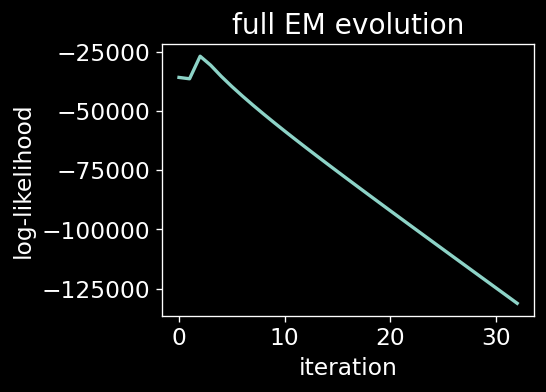

In [33]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
full_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("full EM evolution");

In [34]:
full_EM_preds = full_EM_shift_probs.argmax(axis=1)

In [35]:
for phase in ['test']:
    y = Y_comb[phase]
    y_pred = full_EM_preds
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'full EM: {phase} true pos'] = true_pos
    label_dists_df[f'full EM: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

,shape,color,global samples,global freq,train samples,train freq,val samples,val freq,test samples,test freq,state,multi-class: train soft pred prior,multi-class: train true pos,multi-class: train acc,multi-class: test soft pred prior,multi-class: test true pos,multi-class: test acc,full EM: test pred prior,full EM: test true pos,full EM: test acc
comb idx,,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,6841.0,0.084501,373,0.079735,306,0.039637,seen,0.071852,4834.0,0.706622,0.061789,212.0,0.692810,5.734902e-04,3.0,0.692810
1,cube,brown,7508,0.041711,6790.0,0.083871,376,0.080376,342,0.044301,seen,0.084775,6656.0,0.980265,0.081641,334.0,0.976608,3.566206e-02,200.0,0.976608
2,cube,cyan,7344,0.040800,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000011,NaN,NaN,0.000011,NaN,NaN,6.468334e-08,NaN,NaN
3,cube,gray,7552,0.041956,6793.0,0.083908,405,0.086575,354,0.045855,seen,0.086750,5646.0,0.831150,0.049058,296.0,0.836158,1.378402e-09,NaN,0.836158
4,cube,green,7346,0.040811,6611.0,0.081660,390,0.083369,345,0.044689,seen,0.081577,6609.0,0.999697,0.176642,345.0,1.000000,8.702908e-02,186.0,1.000000
5,cube,purple,7565,0.042028,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000008,NaN,NaN,0.000009,NaN,NaN,3.707519e-03,NaN,NaN
6,cube,red,7458,0.041433,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000009,NaN,NaN,0.000009,NaN,NaN,2.267118e-01,159.0,NaN
7,cube,yellow,7707,0.042817,NaN,NaN,5,0.001069,300,0.038860,unseen,0.000014,NaN,NaN,0.000012,NaN,NaN,2.598625e-20,NaN,NaN
8,cylinder,blue,7338,0.040767,6658.0,0.082240,382,0.081659,298,0.038601,seen,0.088110,6088.0,0.914389,0.091092,281.0,0.942953,3.397365e-10,NaN,0.942953


# Summary

In [36]:
result_cols = label_cols + ['state', 'train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc',
    'full EM: test acc']
results_df = label_dists_df[result_cols]
# results_df = results_df.sort_values(by='train freq', ascending=False)
with pd.option_context('display.float_format',"{:,.3%}".format):
    display(results_df)

,shape,color,state,train freq,test freq,multi-class: train acc,multi-class: test acc,full EM: test acc
comb idx,,,,,,,,
0,cube,blue,seen,8.450%,3.964%,70.662%,69.281%,69.281%
1,cube,brown,seen,8.387%,4.430%,98.027%,97.661%,97.661%
2,cube,cyan,unseen,NaN,3.886%,NaN,NaN,NaN
3,cube,gray,seen,8.391%,4.585%,83.115%,83.616%,83.616%
4,cube,green,seen,8.166%,4.469%,99.970%,100.000%,100.000%
5,cube,purple,unseen,NaN,3.886%,NaN,NaN,NaN
6,cube,red,unseen,NaN,3.886%,NaN,NaN,NaN
7,cube,yellow,unseen,NaN,3.886%,NaN,NaN,NaN
8,cylinder,blue,seen,8.224%,3.860%,91.439%,94.295%,94.295%


In [37]:
core_result_cols = ['multi-class: train acc', 'multi-class: test acc', 'full EM: test acc']
# -------------------------------------------------------------------

core_result_dict = {}
for state in ['seen', 'unseen']:
    core_result_dict[state] = results_df.query(f"state == '{state}'")[core_result_cols].fillna(0).mean(0)
core_result_dict['all'] = results_df[core_result_cols].fillna(0).mean(0)
core_result_df = pd.DataFrame.from_dict(core_result_dict, orient='index')
with pd.option_context('display.float_format',"{:,.1%}".format):
    display(core_result_df)

,multi-class: train acc,multi-class: test acc,full EM: test acc
seen,93.6%,93.6%,93.6%
unseen,0.0%,0.0%,0.0%
all,46.8%,46.8%,46.8%


# Comparison

In [38]:
comparison_df = pd.read_excel('analysis\AO-Clevr 5000.xlsx')
comparison_df = comparison_df.fillna(0)
comparison_df

,ratio,state,multi-class: train acc,multi-class: test acc,full EM: test acc
0,0.000,seen,0.895,0.891,0.891
1,0.000,unseen,0.000,0.000,0.000
2,0.000,all,0.447,0.446,0.446
3,0.100,seen,0.893,0.894,0.894
4,0.100,unseen,0.535,0.539,0.539
5,0.100,all,0.714,0.716,0.716
6,0.010,seen,0.901,0.904,0.904
7,0.010,unseen,0.295,0.258,0.258
8,0.010,all,0.598,0.581,0.581
9,0.001,seen,0.902,0.898,0.898


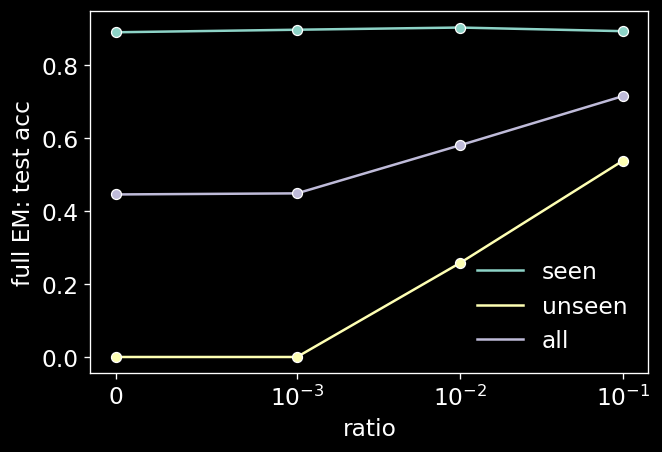

In [39]:
y_col = 'full EM: test acc'
# y_col = 'multi-class: test acc'
# ---------------------------
sns.lineplot(data=comparison_df, x='ratio', y=y_col, hue='state', marker="o")
plt.legend(title='', frameon=False)
plt.xscale('symlog', linthresh=1e-3)